# NIRISS AMI: Binary fitting of AB Dor using Fouriever

## Introduction
This notebook takes a calibrated OIFITS file (see _Defining Terms_ below) from NIRISS Aperture Masking Interferometry (AMI) data of binary point source AB Dor and calibrator HD 37093. The data were observed during science instrument commissioning on June 5, 2022, calibrated with the [JWST pipeline](https://jwst-pipeline.readthedocs.io/en/latest/index.html), and had interferometric observables extracted using the Image Plane approach to Interferometric Analysis ([ImPlaneIA](http://ascl.net/1808.004)). This notebook estimates the parameters of a best-fit binary model for this data.

We use the [fouriever](https://github.com/kammerje/fouriever) analysis package to extract binary point source parameters. It utilizes model-fitting and chi-squared minimization, taking into account correclations between interferometric observables and bandwidth smearing effects at long baselines, to find the most probable location of a stellar companion. 

### Defining terms

**Observables** here refers to interferometric observables: quantities that can be measured from an interferogram. We use squared visibilities and closure phases from the fringe amplitudes and fringe phases of the observed scene.

**[OIFITS](https://doi.org/10.1051/0004-6361/201526405)** files are the Optical Interferometry standard FITS files used by the community. A science target's observables are **calibrated** by the observables of a PSF calibrator star's image, to remove telescope/instrument effects (as far as possible).

**Fouriever** is a toolkit for analyzing non-redundant masking and kernel phase interferometry data. Details of the analysis methods are described in [Kammerer et al. 2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.486..639K/abstract), [2020](https://ui.adsabs.harvard.edu/abs/2020A%26A...644A.110K/abstract). 


***

## Imports

- *numpy* to handle array functions
- *zipfile* for accessing zip file
- *urllib.request* to access URL
- *os* and *pathlib* for path manipulation

- *astropy.io fits* for accessing FITS files
- *matplotlib.pyplot* for plotting data
- *scipy.ndimage* for image handling
- *IPython.display* for image display
- *fouriever* high-contrast companion detection

In [1]:
%matplotlib inline

import numpy as np
import os
import zipfile
import urllib.request
from pathlib import Path

from astropy.io import fits
import matplotlib.pyplot as plt
from scipy import ndimage
from IPython.display import Image
from fouriever import intercorr, uvfit

***



The provided data is a NIRISS AMI observation of a binary star: a 4.61 $M_L$ K0V primary (AB Dor A) with a faint companion. On the date these data were taken, we expect to observe the following characteristics of the binary system in filter F480M:  
- Magnitude difference: dm = 4.2 mag at 4.8 μm (a flux ratio of 48)
- Sub-λ/D separation: sep = 370.98 mas
- Position angle: theta = 286.98 degrees (from North)
  

In [2]:
# These are the binary parameters we expect Fouriever to extract

sep = 370.98  # binary separation [mas]
theta = 286.98  # position angle (pa) [deg]
dm = 4.2  # delta magnitude [mag]

## Loading data
Load the input data file. This is the science target's calibrated oifits file, created by running `2_niriss_ami_binary.ipynb`. The zipped file also includes a simulated FITS image with the faint companion artificially brightened so we can examine its position relative to the host star.

In [3]:
# Download the products

boxlink = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/niriss_ami_binary/niriss_ami_binary3.zip'
boxfile = Path('./niriss_ami_binary3.zip')

# Download zip file
if not boxfile.exists():
    urllib.request.urlretrieve(boxlink, boxfile)
    zf = zipfile.ZipFile(boxfile, 'r')
    zf.extractall()

In [4]:
# The data file is now in the 'niriss_ami_binary3' directory
calib_oifits = './niriss_ami_binary3/calib_abdor_f480m_pos1_hd37093.oifits'
datadir = os.path.dirname(calib_oifits)
print(os.path.abspath(calib_oifits))

/home/runner/work/jdat_notebooks/jdat_notebooks/notebooks/niriss_ami_binary/niriss_ami_binary3/calib_abdor_f480m_pos1_hd37093.oifits


## File Information
The science target's calibrated oifits file needs to have interferometric observables corresponding to all possible baselines in the non-redundant mask, and their associated uncertainties. The uncertainty on each observable is taken to be the "straight" standard deviation (without consideration for linear dependence within a set of variables).
OIFITS files are multi-extension FITS binary tables.

The file contains seven extensions. The primary data extension is empty, and the remaining six extensions binary tables contain information about the observations and the interferometric data.
* **OI_WAVELENGTH**: Bandpass info (e.g. weighted central wavelength) 
* **OI_TARGET**: Properties of the target retrieved from SIMBAD, observation date and duration
* **OI_ARRAY**: Telescope info (e.g. sub-aperture locations, primary mirror diameter) 
* **OI_VIS**: Fringe visibility amplitudes and phases (calibrated visibility amplitudes of the target, corresponding to 21 baselines)
* **OI_VIS2**: Squared visibility amplitudes and phases (calibrated squared visibility of the target, corresponding to 21 baselines)
* **OI_T3**: Triple product amplitudes and phases (calibrated closure phases of the target corresponding to 35 triangles between sub-apertures)

In [5]:
# Display OIFITS file information
fits.info(calib_oifits)

Filename: ./niriss_ami_binary3/calib_abdor_f480m_pos1_hd37093.oifits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   ()      
  1  OI_WAVELENGTH    1 BinTableHDU     17   1R x 2C   [1E, 1E]   
  2  OI_TARGET     1 BinTableHDU     56   1R x 17C   [1I, 16A, 1D, 1D, 1E, 1D, 1D, 1D, 8A, 8A, 1D, 1D, 1D, 1D, 1E, 1E, 16A]   
  3  OI_ARRAY      1 BinTableHDU     37   7R x 8C   [16A, 16A, 1I, 1E, 3D, 1D, 6A, 2D]   
  4  OI_VIS        1 BinTableHDU     44   21R x 12C   [1I, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 2I, 1L]   
  5  OI_VIS2       1 BinTableHDU     38   21R x 10C   [1I, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 2I, 1L]   
  6  OI_T3         1 BinTableHDU     50   35R x 14C   [1I, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 3I, 1L]   


The primary header tells us some information about the contents, such as the telescope (JWST), aperture mask design used (g7s6), the name of the target (AB Dor), and the name of the calibrator (HD37093):

In [6]:
# Display primary header contents
fits.getheader(calib_oifits)

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
DATE    = '2022-06-06'                                                          
ORIGIN  = 'STScI   '                                                            
DATE-OBS= '2022-06-05T00:00:00.000'                                             
CONTENT = 'OIFITS2 '                                                            
TELESCOP= 'JWST    '                                                            
INSTRUME= 'NIRISS  '                                                            
OBSERVER= 'UNKNOWN '                                                            
OBJECT  = 'AB DOR  '                                                            
INSMODE = 'NRM     '        

## Examine the data

First, we will plot the interferometric observables we will be fitting with Fouriever. These are the 35 closure phases and 21 squared visibilities of the AB Dor observation, calibrated by our reference star HD 37093. We will plot observables against $B_{max}/\lambda$, where $B_{max}$ is the baseline between the centers of two sub-apertures (for squared visibility) or the longest of the three baselines between three sub-apertures (for closure phase) and $\lambda$ is the central wavelength of the filter (4.82 $\mu$m)

In [7]:
# Your input data is an oifits file
with fits.open(calib_oifits) as hdu:
    cp_ext = hdu['OI_T3'].data
    sqvis_ext = hdu['OI_VIS2'].data
    oiarray = hdu['OI_ARRAY'].data
    wavel = hdu['OI_WAVELENGTH'].data['EFF_WAVE']
    pscale = hdu['OI_ARRAY'].header['PSCALE']
    pav3 = hdu[0].header['PA']
print('Wavelength: %.2e m' % wavel)
print('V3 PA: %.2f degrees' % pav3)
cp = cp_ext['T3PHI']
cp_err = cp_ext['T3PHIERR']
tri_idx = cp_ext['STA_INDEX']

sqvis = sqvis_ext['VIS2DATA']
sqvis_err = sqvis_ext['VIS2ERR']
bl_idx = sqvis_ext['STA_INDEX']

hole_ctrs = oiarray['STAXYZ']
hole_idx = oiarray['STA_INDEX']

Wavelength: 4.82e-06 m
V3 PA: 171.88 degrees


In [8]:
# Calculate the length of the baseline [m] for each pair
baselines = []
for bl in bl_idx:
    hole1, hole2 = (bl[0] - 1), (bl[1] - 1)
    x1, y1 = hole_ctrs[hole1][0], hole_ctrs[hole1][1]
    x2, y2 = hole_ctrs[hole2][0], hole_ctrs[hole2][1]
    length = np.abs(np.sqrt((x2 - x1)**2. + (y2 - y1)**2.))
    baselines.append(length)
# Calculate the length of three baselines for each triangle
# Select the longest for plotting
tri_baselines = []
tri_longest = []
for tri in tri_idx:
    hole1, hole2, hole3 = tri[0] - 1, tri[1] - 1, tri[2] - 1
    x1, y1 = hole_ctrs[hole1][0], hole_ctrs[hole1][1]
    x2, y2 = hole_ctrs[hole2][0], hole_ctrs[hole2][1]
    x3, y3 = hole_ctrs[hole3][0], hole_ctrs[hole3][1]
    length12 = np.abs(np.sqrt((x2 - x1)**2. + (y2 - y1)**2.))
    length23 = np.abs(np.sqrt((x3 - x2)**2. + (y3 - y2)**2.))
    length31 = np.abs(np.sqrt((x1 - x3)**2. + (y1 - y3)**2.))
    tri_lengths = [length12, length23, length31]
    tri_baselines.append(tri_lengths)
    tri_longest.append(np.max(tri_lengths))

# Calculate B_max/lambda
bmaxlambda_sqvis = baselines / wavel
bmaxlambda_cp = tri_longest / wavel

# Label baselines and triangles
bl_strings = []
for idx in bl_idx:
    bl_strings.append(str(idx[0])+'_'+str(idx[1]))

tri_strings = []
for idx in tri_idx:
    tri_strings.append(str(idx[0])+'_'+str(idx[1])+'_'+str(idx[2]))

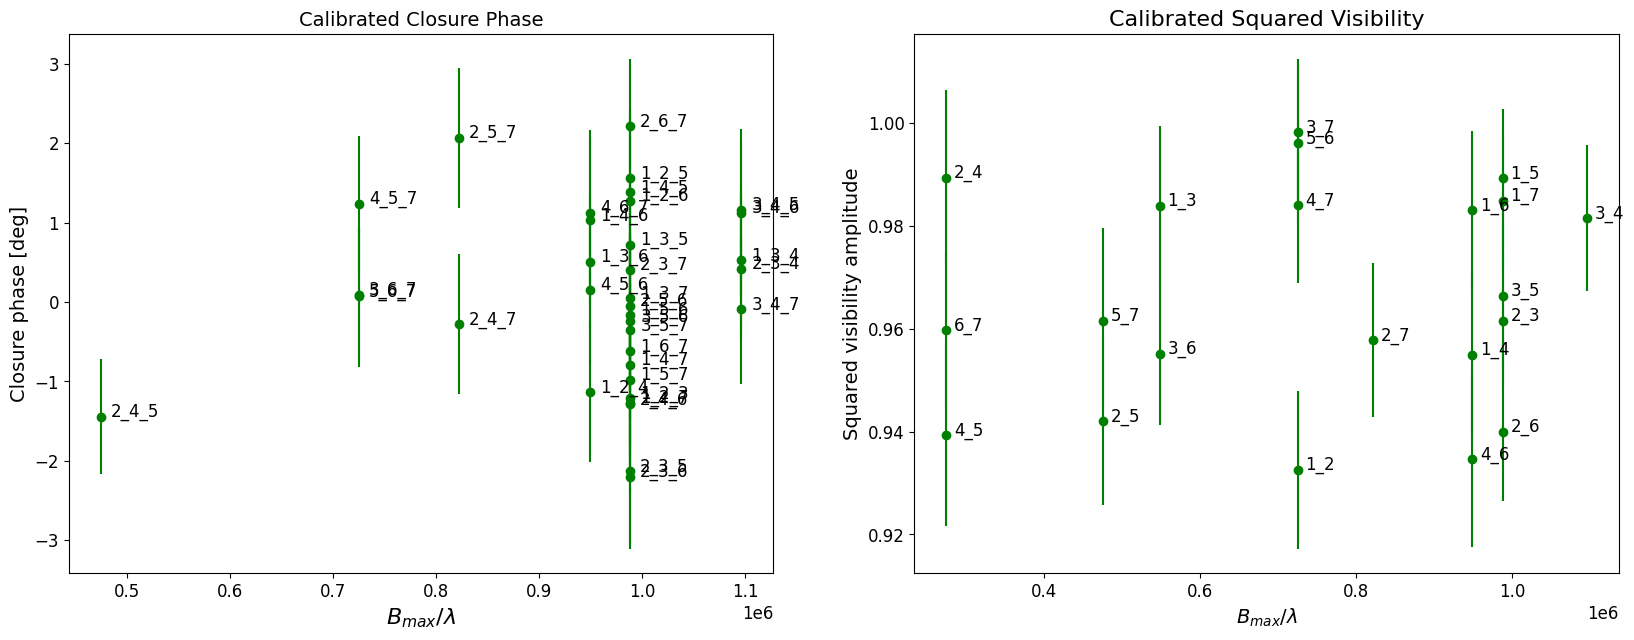

In [9]:
# Plot closure phases, square visibilities
# Label which point corresponds to which hole pair or triple

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
ax1.errorbar(bmaxlambda_cp, cp, yerr=cp_err, fmt='go')
ax1.set_xlabel(r'$B_{max}/\lambda$', size=16)
ax1.set_ylabel('Closure phase [deg]', size=14)
ax1.set_title('Calibrated Closure Phase', size=14)
for ii, tri in enumerate(tri_strings):
    ax1.annotate(tri,
                 (bmaxlambda_cp[ii], cp[ii]),
                 xytext=(bmaxlambda_cp[ii]+10000, cp[ii]))

ax2.errorbar(bmaxlambda_sqvis, sqvis, yerr=sqvis_err, fmt='go')
ax2.set_title('Calibrated Squared Visibility', size=16)
ax2.set_xlabel(r'$B_{max}/\lambda$', size=14)
ax2.set_ylabel('Squared visibility amplitude', size=14)
for ii, bl in enumerate(bl_strings):
    ax2.annotate(bl,
                 (bmaxlambda_sqvis[ii],
                  sqvis[ii]),
                 xytext=(bmaxlambda_sqvis[ii]+10000, sqvis[ii]))

The above plots show the calibrated closure phases (left) and the calibrated squared visibilities (right). Each quantity is plotted against $B_{max}/\lambda$, the baseline length divided by the wavelength of the observation. In the case of closure phases, where the triangle is formed by three baselines, the longest one is selected. 

For a monochromatic observation of a point source, we would expect all 35 closure phases to be zero, and all 21 squared visibilities to be unity. Asymmetries in the target caused by e.g. an unresolved companion cause the closure phases and visibilities corresponding to the baselines between affected sub-apertures to diverge from zero or unity. We can now use the set of calibrated observables to model the most probable location and contrast ratio of the companion. 

## Perform the binary parameter extraction

Fouriever performs a search for faint companions over a coarse grid of starting points for the position of the companion and companion/star flux ratio. A multiparameter fit is performed for each starting position, and the companion position and flux ratio are adjusted, leading to a local $\chi^2$ minimum. Based on the distance each starting point must travel to reach the local minima, Fouriever creates a finer search grid and repeats the process. This iterative process eventually identifies a global minimum in the  $\chi^2$ map. Fouriever also accounts for correlations between observables and bandwidth smearing effects.

Each point on the grid is fitted with a model of a resolved primary star with a point-source companion. The interferometric observables are estimated using a least-squares minimization between the data and model. The significance ($n\sigma$) of the detection is capped at $8\sigma$. 

### Utilize the Fouriever package

In [10]:
# Set up parameters for the binary search grid and output files

rmin = 10 # inner search angle [mas]
rmax = 500 # outer search angle [mas]
step = 25 # grid step size [mas]

obase1 = 'ami_binary_smear_cov.png'

In [11]:
# Load data for covariance calculation
basename = os.path.basename(calib_oifits)
data = intercorr.data(idir=datadir+'/',
                      fitsfiles=[basename])
# Add observable covariances
data.clear_cov()
data.add_cpcov(odir=datadir)

Selected instrument = NIRISS
   Use self.set_inst(inst) to change the selected instrument
Selected observables = ['v2', 'cp']
   Use self.set_observables(observables) to change the selected observables
   Computing closure phase correlations


In [12]:
# Load data for fitting
data = uvfit.data(idir=datadir,
                  fitsfiles=[basename])

# Compute chi-squared map.
fit = data.chi2map(model='bin', # fit unresolved companion
                   cov=True, # this data set has covariance
                   sep_range=(rmin, rmax), # use custom separation range
                   step_size=step, # use custom step size
                   smear=3, # use bandwidth smearing of 3
                   ofile=obase1) # save figures

Opened NIRISS data
   1 observations
   21 baselines
   35 triangles
   1 wavelengths
Selected instrument = NIRISS
   Use self.set_inst(inst) to change the selected instrument
Selected observables = ['v2', 'cp']
   Use self.set_observables(observables) to change the selected observables
Data properties
   Smallest spatial scale = 94.1 mas
   Largest spatial scale = 376.4 mas
   Minimum baseline = 1.32 m
   Maximum baseline = 5.28 m
   Bandwidth smearing = 3
   Using data covariance = True
Computing grid
   Min. sep. = 25.0 mas
   Max. sep. = 500.0 mas
   1256 non-empty grid cells
Computing chi-squared map (DO NOT TRUST UNCERTAINTIES)
   Cell 1681 of 1681
   1255 unique minima found after 1256 fits
   Optimal step size = 25.3 mas
   Current step size = 25.0 mas
   Best fit companion flux = 1.691 +/- 0.014 %
   Best fit companion right ascension = -321.1 +/- 0.6 mas
   Best fit companion declination = 57.3 +/- 0.9 mas
   Best fit companion separation = 326.1 +/- 0.6 mas
   Best fit compa

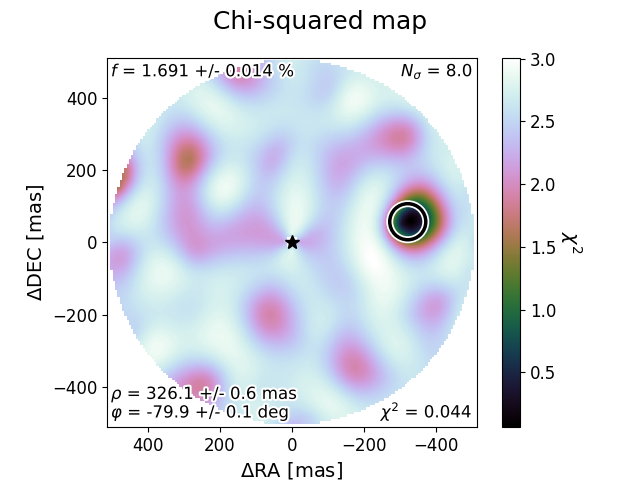

In [13]:
# Display the chi-squared map

Image(obase1[:-4]+'_chi2map.png')

In [14]:
# Run MCMC around best fit position.
fit = data.mcmc(fit=fit, # best fit from gridsearch
                temp=None, # use default temperature (reduced chi-squared of best fit)
                cov=True, # this data set has covariance
                smear=3, # use bandwidth smearing of 3
                ofile=obase1, # save figures
                sampler='emcee') # sampling algorithm

Computing best fit companion parameters (UNCERTAINTIES FROM MCMC)
   Bandwidth smearing = 3
   Using data covariance = True
   Covariance inflation factor = 0.044
   This may take a few minutes


100%|██████████| 5000/5000 [00:05<00:00, 858.86it/s]


   Best fit companion flux = 1.677 +/- 0.028 %
   Best fit companion right ascension = -323.2 +/- 1.3 mas
   Best fit companion declination = 56.4 +/- 1.2 mas
   Best fit companion separation = 328.1 +/- 1.3 mas
   Best fit companion position angle = -80.1 +/- 0.2 deg
   Best fit red. chi2 = 0.041 (bin)
   Significance of companion = 8.0 sigma


In [15]:
# Display MCMC fit results

Image(obase1[:-4]+'_mcmc_corner.png')

FileNotFoundError: No such file or directory: 'ami_binary_smear_cov_mcmc_corner.png'

FileNotFoundError: No such file or directory: 'ami_binary_smear_cov_mcmc_corner.png'

<IPython.core.display.Image object>

The corner plot shows the 1D histograms and 2D contours of the posterior distributions of each pair of binary parameters.

Fouriever produces a plot of the closure phases from the best-fit binary model vs those extracted from the data, and the residual (difference between the data and model, normalized by $\sigma/\chi$):

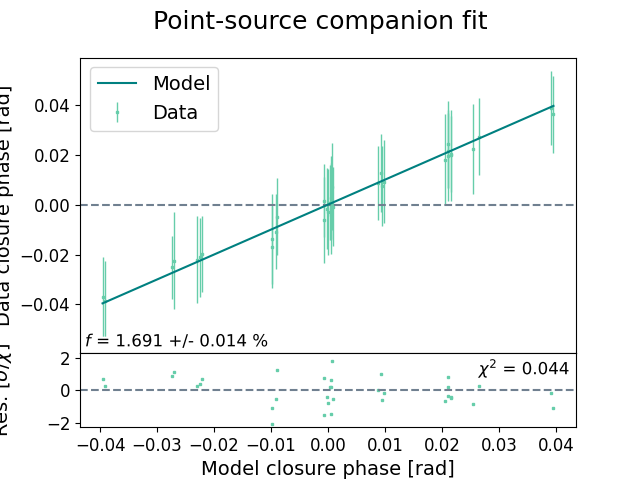

In [16]:
# Display the closure phase model vs. data plot

Image(obase1[:-4]+'_cp_bin.png')

In [17]:
# Compute chi-squared map after subtracting best fit companion.
obase2 = 'ami_binary_smear_cov_sub.png'

fit_sub = data.chi2map_sub(fit_sub=fit, # best fit from MCMC
                           model='bin', # fit unresolved companion
                           cov=True, # this data set has covariance
                           sep_range=(rmin, rmax), # use custom separation range
                           step_size=step, # use custom step size
                           smear=3, # use bandwidth smearing of 3
                           ofile=obase2) # save figures

Subtracting bin model
Data properties
   Smallest spatial scale = 94.1 mas
   Largest spatial scale = 376.4 mas
   Minimum baseline = 1.32 m
   Maximum baseline = 5.28 m
   Bandwidth smearing = 3
   Using data covariance = True
Computing grid
   Min. sep. = 25.0 mas
   Max. sep. = 500.0 mas
   1256 non-empty grid cells
Computing chi-squared map (DO NOT TRUST UNCERTAINTIES)
   Cell 1681 of 1681
   1256 unique minima found after 1256 fits
   Optimal step size = 25.2 mas
   Current step size = 25.0 mas
   Best fit companion flux = 0.081 +/- 0.000 %
   Best fit companion right ascension = -75.0 +/- 0.0 mas
   Best fit companion declination = -150.0 +/- 0.0 mas
   Best fit companion separation = 167.7 +/- 0.0 mas
   Best fit companion position angle = -153.4 +/- 0.0 deg
   Best fit red. chi2 = 0.030 (bin)
   Significance of companion = 2.0 sigma


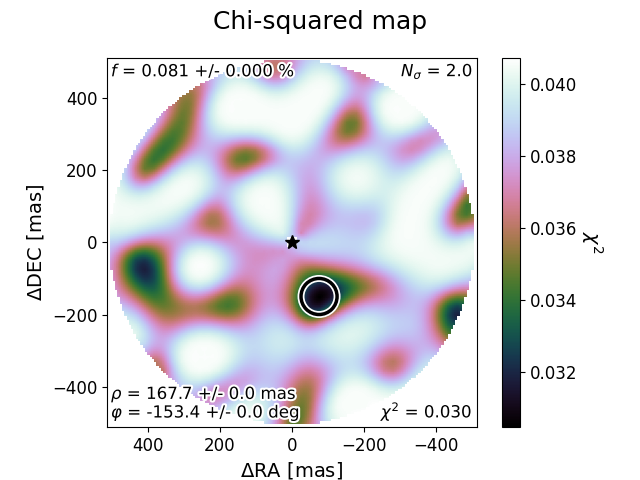

In [18]:
# Display chi-squared map after subtracting the best-fit companion

Image(obase2[:-4]+'_chi2map.png')

This "detection" after the companion is subtracted has a low $N_{\sigma}$ and the symmetry in the map suggests Fourier aliasing at that location, so we do not believe there is a second companion detected here.

### Convert RA, Dec, flux ratio to separation, PA, magnitude difference

Fouriever provides the best-fit offset in right ascension and declination \[mas\], and the flux ratio of companion to primary. These are stored in the fit dictionary produced by Fouriever. We will convert these to position angle, separation, and contrast in magnitudes to compare with our expected values from above:

In [19]:
def mag_diff(flux_ratio):
    # for flux ratio f_a/f_b, calculate magnitude difference m_a - m_b
    return -2.5 * np.log10(flux_ratio)


def convert_params(x, y, f, ex, ey, ef, sigma=1):
    """ 
    'convert' binary params from ra, dec, flux ratio to sep,
    pa, magnitude difference with appropriate errors.
    Multiply errorbars by some sigma factor.
    """
    sep = np.sqrt(x**2 + y**2)
    pa = 360 + np.rad2deg(np.arctan2(x, y))
    dm = mag_diff(f)
    sep_unc = np.sqrt((x/sep*ex)**2+(y/sep*ey)**2) * sigma
    pa_unc = np.rad2deg(np.sqrt((y/sep**2*ex)**2+(-x/sep**2*ey)**2)) * sigma
    dm_upper = mag_diff(f + ef*sigma)
    dm_lower = mag_diff(f - ef*sigma)
    return sep, pa, dm, sep_unc, pa_unc, dm_upper, dm_lower

In [20]:
# Get the best-fit parameters and uncertainties
x, ex = fit["p"][1], fit["dp"][1]
y, ey = fit["p"][2], fit["dp"][2]
f, ef = fit["p"][0], fit["dp"][0]

sep_fit, pa_fit, dm_fit, sep_unc, pa_unc, dm_upper, dm_lower = convert_params(x, y, f, ex, ey, ef)
dm_unc = np.mean([dm-dm_upper, dm_lower-dm]) # symmetrical uncertainties for printing

In [21]:
print('             Expected      Model')
print('Sep [mas]:   %.3f      %.3f +/- %.2f' % (sep, sep_fit, sep_unc))
print('Theta [deg]: %.3f      %.3f +/- %.2f' % (theta, pa_fit, pa_unc))
print('dm [mag]:    %.3f        %.3f +/- %.2f' % (dm, dm_fit, dm_unc))

             Expected      Model
Sep [mas]:   370.980      328.134 +/- 1.31
Theta [deg]: 286.980      279.905 +/- 0.21
dm [mag]:    4.200        4.439 +/- 0.02


We notice that there is a significant difference between the expected and retrieved binary parameters, most notably the separation. Since the expected parameters were derived from astrometric measurements of AB Dor, the most recent of which was in 2007 (HIP2), there were large uncertainties on these values. We think it is probable that the observed position is the real position of the companion.


### Calculate the contrast limits

Next, we will use Fouriever to find the detection limit at different angular separations. To do this, Fouriever subtracts the best-fit companion and then injects an additional companion at each grid position with different flux ratios and estimates the number of sigma for a theoretical detection at that point. It interpolates the flux ratio values at 3$\sigma$ for all points in the grid to produce a 3$\sigma$ detection map of the contrast (flux) ratio. 

It also uses the Absil method, which differs slightly from the injection method in that it assumes that the uniform disk is the true model when evaluating the probability of a binary existing at a given grid position, while the injection method assumes the binary is the true model (see [Absil et al. 2011](https://ui.adsabs.harvard.edu/abs/2011A%26A...535A..68A/abstract), [Gallenne et al. 2015](https://ui.adsabs.harvard.edu/abs/2015A%26A...579A..68G/abstract) for more details).

In [22]:
# Estimate detection limits using the injection and Absil methods
data.detlim(sigma=3., # confidence level of detection limits
            fit_sub=fit, # best fit from MCMC
            cov=True, # this data set has covariance
            sep_range=(rmin, rmax), # use custom separation range
            step_size=step, # use custom step size
            smear=3, # use bandwidth smearing of 3
            ofile=obase2) # save figures

Subtracting bin model
Data properties
   Smallest spatial scale = 94.1 mas
   Largest spatial scale = 376.4 mas
   Minimum baseline = 1.32 m
   Maximum baseline = 5.28 m
   Bandwidth smearing = 3
   Using data covariance = True
Computing best fit uniform disk diameter (DO NOT TRUST UNCERTAINTIES)
   Best fit uniform disk diameter = 5.56617 +/- 0.06510 mas
   Best fit red. chi2 = 0.038 (ud)
Computing grid
   Min. sep. = 25.0 mas
   Max. sep. = 500.0 mas
   1256 non-empty grid cells
Computing detection limits (3-sigma)
   Cell 1681 of 1681


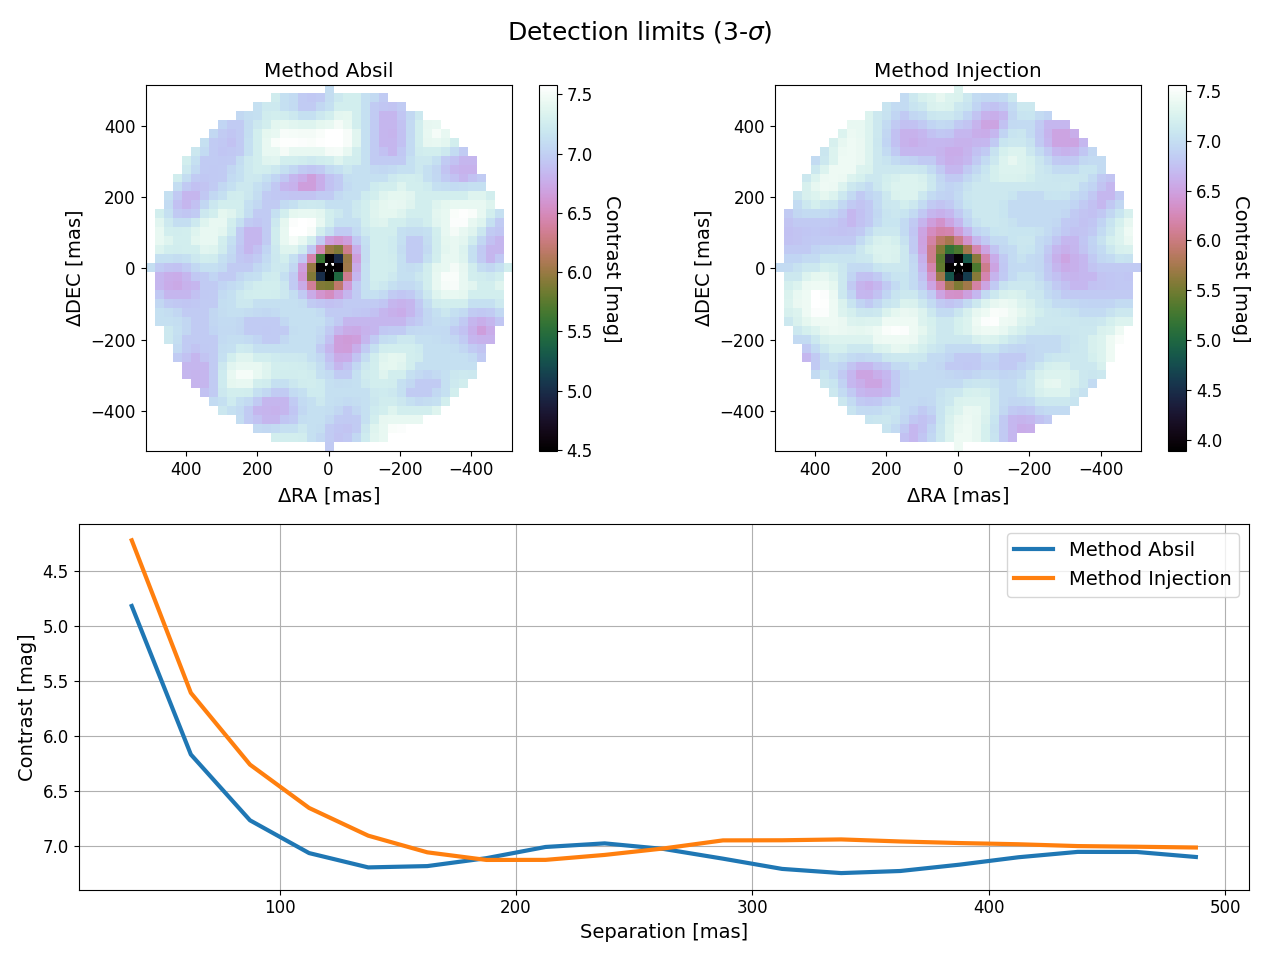

In [23]:
# Display the detection limit plot

Image(obase2[:-4]+'_detlim.png')

The top plots show the detection limit, in terms of contrast ($\Delta$Mag), at each location in the search grid based on the injection/detection of false companions using two slightly different methods. The lower plot shows an estimate of the same detection limit with respect to the angular separation [mas] from the primary target (azimuthally averaged from the top plots).

### Visually compare the position

We can now look at a simulated image with the faint companion artificially brightened, and we see that the position of the primary star at the center and its faint companion appear to match the position of the companion detected on the above $\chi^2$ map output by Fouriever.

Text(0, 0.5, '$\\Delta\\delta$ [mas]')

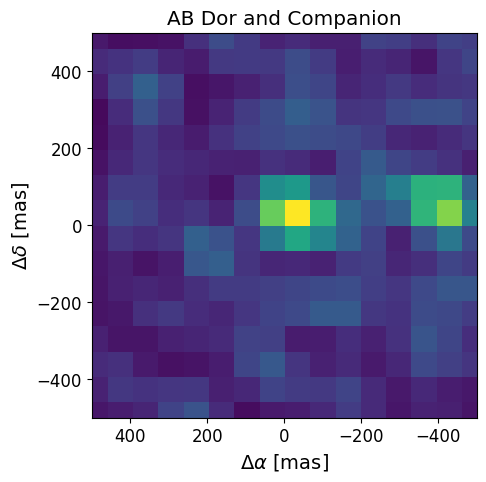

In [24]:
bright_im = fits.getdata('./niriss_ami_binary3/jw01093001001_01101_00001_nis_uncal_F480M_NRM_final_seed_image_fakemag_4.8131.fits')
# center and trim the image around the bright pixel before rotating
bright_idx = np.where(bright_im == np.max(bright_im))
left, right = bright_idx[1][0] - 30, bright_idx[1][0] + 30
down, up = bright_idx[0][0] - 30, bright_idx[0][0] + 30
trimmed = bright_im[down:up, left:right]

# rotate the image by pav3 to match orientation
rot_im = ndimage.rotate(trimmed, pav3+90, reshape=False)
# convert image coordinates from pixels to milliarcsec, centered on target
xsize_px, ysize_px = rot_im.shape[0], rot_im.shape[1]
xsize_mas, ysize_mas = xsize_px*pscale, ysize_px*pscale
bright_loc = np.where(rot_im == np.max(rot_im))
brightx_mas, brighty_mas = bright_loc[1][0]*pscale, bright_loc[0][0]*pscale
xmin, xmax = 0. - brightx_mas, xsize_mas - brightx_mas
ymin, ymax = 0. - brighty_mas, ysize_mas - brighty_mas

# Plot the image on the same scale as Fouriever chi-squared maps above
fig = plt.figure(figsize=(5, 5))
plt.imshow(rot_im, origin='lower', extent=[-xmin, -xmax, ymin, ymax])
plt.xlim([500, -500])
plt.ylim([-500, 500])
plt.title('AB Dor and Companion')
plt.xlabel(r'$\Delta\alpha$ [mas]')
plt.ylabel(r'$\Delta\delta$ [mas]')

The above plot confirms the position of the faint companion relative to the target, shown here as change in right ascension and declination from the center of the target star.

## Additional Resources

- [JWST NIRISS AMI documentation](https://jwst-docs.stsci.edu/near-infrared-imager-and-slitless-spectrograph/niriss-observing-modes/niriss-aperture-masking-interferometry)
- Fouriever development papers:
    - [Kammerer et al. 2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.486..639K/abstract)
    - [Kammerer et al. 2020](https://ui.adsabs.harvard.edu/abs/2020A%26A...644A.110K/abstract)
    - [Kammerer et al. 2021a](https://ui.adsabs.harvard.edu/abs/2021A%26A...646A..36K/abstract)
- [CANDID paper (Galenne et al. 2015)](https://ui.adsabs.harvard.edu/link_gateway/2015A&A...579A..68G/doi:10.1051/0004-6361/201525917)

## About this notebook
**Author:** Rachel Cooper and Anand Sivaramakrishnan's adaptation of example analysis scripts written by Jens Kammerer (STScI) and Anthony Soulain (University of Sydney).
**Updated On:** 2022-20-12

***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 